# Tracking an object using the Kalman filter





Consider an object moving in $R^2$.
We assume that we observe a noisy version of its location at each time step.
We want to track the object and possibly forecast its future motion.
We now show how to do this using a simple linear SDE, combined with 
the Continuous-Discrete Kalman filter algorithm.

Let the hidden state represent
the position and velocity of the object,
$z_t =\begin{pmatrix} u_t & \dot{u}_t & v_t & \dot{v}_t \end{pmatrix}$.
(We use $u$ and $v$ for the two coordinates,
to avoid confusion with the state and observation variables.)
The process evolves continuously according to the following linear stochastic differential equation:

\begin{align*}
\frac{d}{dt}\underbrace{\begin{pmatrix} u_t\\ \dot{u}_t \\ v_t \\ \dot{v}_t \end{pmatrix}}_{z_t}
  = 
\underbrace{
\begin{pmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0
\end{pmatrix}
}_{F}
\underbrace{\begin{pmatrix} u_{t} \\ \dot{u}_{t} \\ v_{t} \\ \dot{v}_{t} \end{pmatrix}}_{z_{t}}
+ Q \dot{w}
\end{align*}

where $Q \in R^{4x4}$ s.p.d. and $w$ is Browinian motion in $R^4$.

Now suppose that at discrete time points we
observe the location (but not the velocity).
We assume the observation is corrupted by  Gaussian noise.
Thus the observation model becomes

\begin{align*}
\underbrace{\begin{pmatrix}  y_{1,t} \\  y_{2,t} \end{pmatrix}}_{y_t}
  &=
    \underbrace{
    \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0
    \end{pmatrix}
    }_{H}
    \;
\underbrace{\begin{pmatrix} u_t\\ \dot{u}_t \\ v_t \\ \dot{v}_t \end{pmatrix}}_{z_t}    
 + r_t
\end{align*}

where $r_t \sim N(0,R)$ is the observation noise.
We see that the observation matrix $H$ simply ``extracts'' the
relevant parts  of the state vector.


## Setup

In [1]:
import sys
from jax import numpy as jnp
from jax import random as jr
from jax import vmap
from matplotlib import pyplot as plt

# Local dynamax 
sys.path.append('..')
from dynamax.utils.plotting import plot_uncertainty_ellipses
# from dynamax.linear_gaussian_ssm import LinearGaussianSSM
# from dynamax.linear_gaussian_ssm import lgssm_smoother, lgssm_filter

# Our codebase
from continuous_discrete_linear_gaussian_ssm import ContDiscreteLinearGaussianSSM
from continuous_discrete_linear_gaussian_ssm import cdlgssm_smoother, cdlgssm_filter


/usr/local/anaconda3/envs/hduq/lib/python3.11/site-packages/equinox/_ad.py:733: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(


## Create the model

In [2]:
state_dim = 4
emission_dim = 2
delta = 1.0

# TODO: properly initialize dynamics weights
initial_mean = jnp.array([8.0, 10.0, 1.0, 0.0])
initial_covariance = jnp.eye(state_dim) * 0.1
dynamics_weights  = jnp.array([[0, 0, 1, 0],
                               [0, 0, 0, 1],
                               [0, 0, 0, 0],
                               [0, 0, 0, 0]])
dynamics_diffusion_covariance = jnp.eye(state_dim) * 0.001
emission_weights = jnp.array([[1.0, 0, 0, 0],
                              [0, 1.0, 0, 0]])
emission_covariance = jnp.eye(emission_dim) * 0.5


# Randomness
key1, key2 = jr.split(jr.PRNGKey(0))

# Model def
inputs = None # Not interested in inputs for now
lgssm = ContDiscreteLinearGaussianSSM(state_dim=state_dim, emission_dim=emission_dim)
params, param_props = lgssm.initialize(key1,
                                        initial_mean=initial_mean,
                                        initial_covariance=initial_covariance,
                                        dynamics_weights=dynamics_weights,
                                        dynamics_diffusion_covariance=dynamics_diffusion_covariance,
                                        emission_weights=emission_weights,
                                        emission_covariance=emission_covariance)




## Sample some data from the model

In [3]:
# create observation times


In [4]:
def generate_sorted_gamma_array(N, shape_param, scale_param, rng_key):
    # Generate random values from a gamma distribution.
    gamma_values = jr.gamma(rng_key, shape_param, shape=(N,)) * scale_param
    
    # Sort the array.
    sorted_values = jnp.sort(gamma_values)
    
    return sorted_values

num_timesteps = 40
shape_param = 2.0  # Shape parameter of the gamma distribution
scale_param = 1.0  # Scale parameter of the gamma distribution
rng_key = jr.PRNGKey(0)  # Initialize a random key
t_emissions = generate_sorted_gamma_array(num_timesteps, shape_param, scale_param, rng_key)
t_emissions = t_emissions[:,None]
# print(t_emissions)


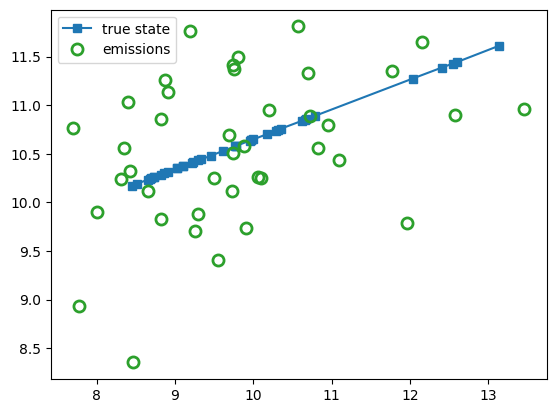

In [5]:
key = jr.PRNGKey(310)
x, y = lgssm.sample(
    params,
    key2,
    num_timesteps=num_timesteps,
    t_emissions=t_emissions,
    inputs=inputs
)

# Plot Data
observation_marker_kwargs = {"marker": "o", "markerfacecolor": "none", "markeredgewidth": 2, "markersize": 8}
fig1, ax1 = plt.subplots()
ax1.plot(*x[:, :2].T, marker="s", color="C0", label="true state")
ax1.plot(*y.T, ls="", **observation_marker_kwargs, color="tab:green", label="emissions")
ax1.legend(loc="upper left")



In [6]:

def plot_lgssm_posterior(post_means, post_covs, ax=None, ellipse_kwargs={}, legend_kwargs={}, **kwargs):
    """Plot posterior means and covariances for the first two dimensions of
     the latent state of a LGSSM.

    Args:
        post_means: array(T, D).
        post_covs: array(T, D, D).
        ax: matplotlib axis.
        ellipse_kwargs: keyword arguments passed to matplotlib.patches.Ellipse().
        **kwargs: passed to ax.plot().
    """
    if ax is None:
        fig, ax = plt.subplots()

    # This is to stop some weird behaviour where running the function multiple
    # #  times with an empty argument wouldn't reset the dictionary.
    # if ellipse_kwargs is None:
    #     ellipse_kwargs = dict()

    # if 'edgecolor' not in ellipse_kwargs:
    #     if 'color' in kwargs:
    #         ellipse_kwargs['edgecolor'] = kwargs['color']

    # Select the first two dimensions of the latent space.
    post_means = post_means[:, :2]
    post_covs = post_covs[:, :2, :2]

    # Plot the mean trajectory
    ax.plot(post_means[:, 0], post_means[:, 1], **kwargs)
    # Plot covariance at each time point.
    plot_uncertainty_ellipses(post_means, post_covs, ax, **ellipse_kwargs)

    ax.axis("equal")

    if "label" in kwargs:
        ax.legend(**legend_kwargs)

    return ax

## Perform online filtering



In [7]:
# lgssm_posterior = cdlgssm_filter(params, y, t_emissions, inputs)
lgssm_posterior = lgssm.filter(params, y, t_emissions, inputs)
# lgssm_posterior = lgssm.filter(params, y)
print(lgssm_posterior.filtered_means.shape)
print(lgssm_posterior.filtered_covariances.shape)
print(lgssm_posterior.marginal_loglik)



(40, 4)
(40, 4, 4)
-90.13489


<Axes: >

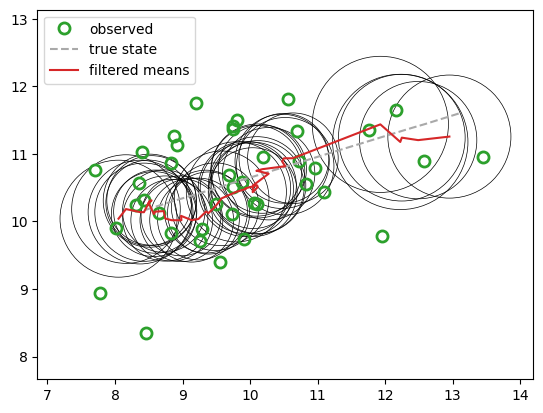

In [8]:
fig2, ax2 = plt.subplots()
ax2.plot(*y.T, ls="", **observation_marker_kwargs, color="tab:green", label="observed")
ax2.plot(*x[:, :2].T, ls="--", color="darkgrey", label="true state")
plot_lgssm_posterior(
    lgssm_posterior.filtered_means,
    lgssm_posterior.filtered_covariances,
    ax2,
    color="tab:red",
    label="filtered means",
    ellipse_kwargs={"edgecolor": "k", "linewidth": 0.5},
    legend_kwargs={"loc":"upper left"}
)

## Perform offline smoothing

In [9]:
lgssm_posterior = lgssm.smoother(params, y, t_emissions, inputs)

<Axes: >

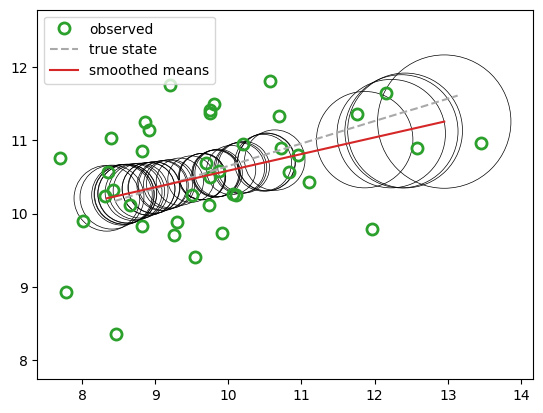

In [10]:
fig3, ax3 = plt.subplots()
ax3.plot(*y.T, ls="", **observation_marker_kwargs, color="tab:green", label="observed")
ax3.plot(*x[:, :2].T, ls="--", color="darkgrey", label="true state")
plot_lgssm_posterior(
    lgssm_posterior.smoothed_means,
    lgssm_posterior.smoothed_covariances,
    ax3,
    color="tab:red",
    label="smoothed means",
    ellipse_kwargs={"edgecolor": "k", "linewidth": 0.5},
    legend_kwargs={"loc":"upper left"}
)

## Low-level interface to the underlying inference algorithms

We can also call the inference code directly, without having to make an LG-SSM object.
We just pass the model parameters directly to the function.

In [11]:
filtered_posterior = cdlgssm_filter(params, y, t_emissions, inputs) # Kalman filter
smoothed_posterior = cdlgssm_smoother(params, y, t_emissions, inputs) # Kalman filter + smoother
assert jnp.allclose(lgssm_posterior.filtered_means, filtered_posterior.filtered_means)
assert jnp.allclose(lgssm_posterior.filtered_means, smoothed_posterior.filtered_means)
assert jnp.allclose(lgssm_posterior.smoothed_means, smoothed_posterior.smoothed_means)

## Tracking multiple objects in parallel


In [12]:
num_samples = 4
key = jr.PRNGKey(310)
keys = jr.split(key, num_samples)

# Generate sorted gamma arrays
t_emissions_arrays = vmap(lambda key: generate_sorted_gamma_array(num_timesteps, shape_param, scale_param, key))(keys)

# Assuming lgssm.sample accepts a single sorted gamma array for t_emissions
def sample_with_emissions(key, t_emissions):
    return lgssm.sample(params, key, num_timesteps=num_timesteps, t_emissions=t_emissions[:,None], inputs=inputs)

# Use vmap to sample from lgssm with different t_emissions
sample_func = vmap(sample_with_emissions)
xs, ys = sample_func(keys, t_emissions_arrays)


In [13]:
# vmap the inference
lgssm_posteriors = vmap(lambda y: lgssm.smoother(params, y))(ys)

In [14]:
def plot_kf_parallel(xs, ys, lgssm_posteriors):
    num_samples = len(xs)
    dict_figures = {}

    # Plot Data
    fig, ax = plt.subplots()
    for n in range(num_samples):
        ax.plot(*xs[n, :, :2].T, ls="--", color=f"C{n}")
        ax.plot(*ys[n, ...].T, ".", color=f"C{n}", label=f"Trajectory {n+1}")
    ax.set_title("Data")
    ax.legend()
    dict_figures["missiles_latent"] = fig

    # Plot Filtering
    fig, ax = plt.subplots()
    for n in range(num_samples):
        ax.plot(*ys[n, ...].T, ".")
        filt_means = lgssm_posteriors.filtered_means[n, ...]
        filt_covs = lgssm_posteriors.filtered_covariances[n, ...]
        plot_lgssm_posterior(
            filt_means,
            filt_covs,
            ax,
            color=f"C{n}",
            ellipse_kwargs={"edgecolor": f"C{n}", "linewidth": 0.5},
            label=f"Trajectory {n+1}",
        )
    ax.legend(fontsize=10)
    ax.set_title("Filtered Posterior")
    dict_figures["missiles_filtered"] = fig

    # Plot Smoothing
    fig, ax = plt.subplots()
    for n in range(num_samples):
        ax.plot(*ys[n, ...].T, ".")
        filt_means = lgssm_posteriors.smoothed_means[n, ...]
        filt_covs = lgssm_posteriors.smoothed_covariances[n, ...]
        plot_lgssm_posterior(
            filt_means,
            filt_covs,
            ax,
            color=f"C{n}",
            ellipse_kwargs={"edgecolor": f"C{n}", "linewidth": 0.5},
            label=f"Trajectory {n+1}",
        )
    ax.legend(fontsize=10)
    ax.set_title("Smoothed Posterior")
    dict_figures["missiles_smoothed"] = fig

    return dict_figures

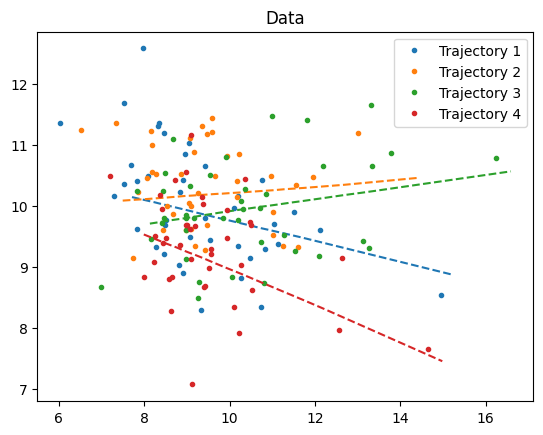

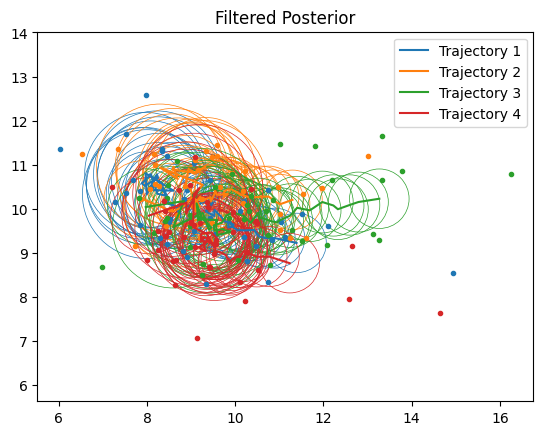

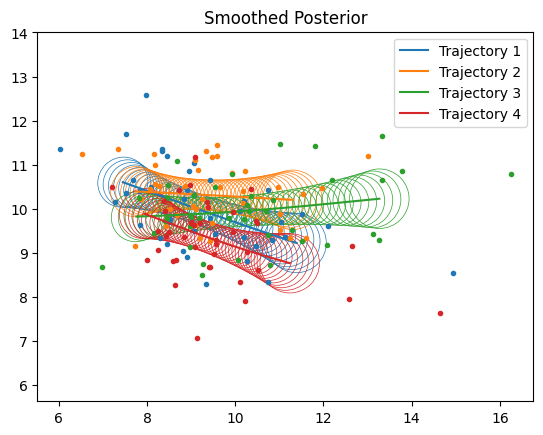

In [15]:
dict_figures = plot_kf_parallel(xs, ys, lgssm_posteriors)